In [83]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
np.random.seed(0)
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
NOTEBOOK_NAME = 'decoding_confusion_across_sess_ALL'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [5]:
# use `save_worspace(db)` to save variables at the end
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42

In [6]:
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
cv = LeaveOneOut()

decoder = LinearSVC()

In [19]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [60]:
import h5py
def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if relabel_test is not None:
        labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
    else:
        if relabel is not None:
            labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
        else:
            labels_comb_test = labels_comb_test_
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test

    return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
            patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])

In [61]:
#for confusion matrix (use predict instead of score)
def do_prediction_combined_within(animals, patterns, labels, ncells=None, cellreg=False, n_steps=15, **args):
    
    scores, test_labels = do_predict_within(patterns, labels, **args) #had to remove n_loops to be able to extract 'test_labels'
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in animals])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells, test_labels_ncells = np.r_[[do_predict_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, test_labels, ncells, scores_ncells, test_labels_ncells

def do_predict_within(patterns, labels, **args):
    x, y, xT, test_labels = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.predict(xT), test_labels

In [8]:
#for confusion matrix (use predict instead of score)
#def do_prediction_combined_across(patterns_train,labels_train,patterns_test,labels_test,ncells=None,n_steps=10,**args):
#    
#    #scores, test_labels = do_predict_across(patterns, labels, **args) #had to remove n_loops to be able to extract 'test_labels'
#    
#    if ncells is None:
#        total_n = np.sum([patterns_train[ani].shape[1] for ani in patterns_train.keys()])
#        ncells = np.r_[np.linspace(2, total_n, n_steps).astype(int)]
#    else:
#        ncells = np.r_[np.linspace(2, ncells, n_steps).astype(int)]
#        
#    #test_scores_ncells, test_labels_ncells,train_scores_ncells,train_labels_ncells = np.r_[[do_predict_across(patterns_train,labels_train,patterns_test,labels_test,train_test_split=0.5,n_cells=n,**args) for n in ncells]]
#    ncells_scores = np.r_[[do_predict_across(patterns_train,labels_train,patterns_test,labels_test,n_cells=n,**args) for n in ncells]]
#    
#    return ncells_scores,ncells

def do_predict_cross_session(patterns_t, labels_t, patterns_T, labels_T, n_cells=None, classes=None,train_test_split=0.5,relabel=None):
    if classes==None:
        classes=[0,1]
    which_train = {}
    which_test = {}
    for ani in patterns_t.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l >=0:
                wt = np.random.permutation(np.where(labels_t[ani]==l)[0])
                if train_test_split<1:
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                else:
                    which_trains.append(wt)
                wT = np.random.permutation(np.where(labels_T[ani]==l)[0])
                if train_test_split<1:
                    which_tests.append(wT[:int(len(wT)*train_test_split)])
                    which_tests.append(wT)
                else:
                    which_tests.append(wT)
        which_train[ani] = np.concatenate(which_trains)
        which_test[ani] = np.concatenate(which_tests)       
                
    
    patterns_dt = patterns_t.copy()
    labels_dt = labels_t.copy()
    patterns_dT = patterns_T.copy()
    labels_dT = labels_T.copy()
    for ani in patterns_t.keys():
        patterns_dt[ani] = patterns_dt[ani][which_train[ani]]
        labels_dt[ani] = labels_dt[ani][which_train[ani]]
        patterns_dT[ani] = patterns_dT[ani][which_test[ani]]
        labels_dT[ani] = labels_dT[ani][which_test[ani]]
        
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_dt, labels_dt,classes=classes)
    patterns_comb_test, labels_comb_ = ut.combine_patterns(patterns_dT, labels_dT,classes=classes)
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
        print len(cells),
    elif n_cells > patterns_comb_train.shape[1]:
        cells = list(range(patterns_comb_train.shape[1]))
        #print len(cells),
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        #print cells.shape,
    
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    prediction_test = decoder.predict(patterns_comb_test[:, cells])
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    prediction_train = decoder.predict(patterns_comb_train[:, cells])
    return prediction_train,prediction_test,labels_comb

In [9]:
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None, cmap='viridis',
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = pl.gca()

    # Plot the heatmap
    im = ax.imshow(data, cmap, origin="lower", **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontsize=7)
    ax.set_yticklabels(row_labels, fontsize=7)

    # Let the horizontal axes labeling appear on top.
    #ax.tick_params(top=True, bottom=False,
    #               labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    pl.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Turn spines off and create white grid.
    #for edge, spine in ax.spines.items():
    #    spine.set_visible(False)

    #ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    #ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    ax.tick_params(axis='both', bottom=False, left=False,pad=0)

    return im#, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["white", "black"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [23]:
dhpc_all_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_expo_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_pre_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36', #,'dhpcg20' #dHPC20 performed very well on day 1 (d' = 2)
dhpc_d2_animals =  'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_post_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_renew_animals = '       dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_ext2_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_ext1_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'

vhpc_all_animals  = np.loadtxt('../allmice.txt', dtype=str)
vhpc_expo_animals = np.loadtxt('../expo_mice.txt', dtype=str)
vhpc_pre_animals  = np.loadtxt('../pre_mice.txt', dtype=str)
vhpc_d2_animals =  'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m8', '90', '91', '92','93'
vhpc_post_animals = np.loadtxt('../post_mice.txt', dtype=str)
vhpc_renew_animals ='c3f3','c3f2','c3m1', 'c3m2', 'c4m3',         'c10m8', '90', '91', '92','93','91b','92b','93b'
vhpc_ext2_animals = np.loadtxt('../ext2_mice.txt', dtype=str)
vhpc_ext1_animals = np.loadtxt('../ext1_mice.txt', dtype=str)

In [24]:
#find animals common to both sessions
vhpc_expopre_animals = np.intersect1d(vhpc_expo_animals, vhpc_pre_animals)
vhpc_expopost_animals = np.intersect1d(vhpc_expo_animals, vhpc_post_animals)
vhpc_prepost_animals = np.intersect1d(vhpc_pre_animals, vhpc_post_animals)
vhpc_pred2_animals = np.intersect1d(vhpc_pre_animals, vhpc_d2_animals)
vhpc_preext1_animals = np.intersect1d(vhpc_pre_animals, vhpc_ext1_animals)
vhpc_preext2_animals = np.intersect1d(vhpc_pre_animals, vhpc_ext2_animals)
vhpc_prerenew_animals = np.intersect1d(vhpc_pre_animals, vhpc_renew_animals)
vhpc_d2post_animals = np.intersect1d(vhpc_d2_animals, vhpc_post_animals)
vhpc_d2ext1_animals = np.intersect1d(vhpc_d2_animals, vhpc_ext1_animals)
vhpc_d2ext2_animals = np.intersect1d(vhpc_d2_animals, vhpc_ext2_animals)
vhpc_d2renew_animals = np.intersect1d(vhpc_d2_animals, vhpc_renew_animals)
vhpc_postext1_animals = np.intersect1d(vhpc_post_animals, vhpc_ext1_animals)
vhpc_postext2_animals = np.intersect1d(vhpc_post_animals, vhpc_ext2_animals)
vhpc_postrenew_animals = np.intersect1d(vhpc_post_animals, vhpc_renew_animals)
vhpc_ext1ext2_animals = np.intersect1d(vhpc_ext1_animals, vhpc_ext2_animals)
vhpc_ext1renew_animals = np.intersect1d(vhpc_ext1_animals, vhpc_renew_animals)
vhpc_ext2renew_animals = np.intersect1d(vhpc_ext2_animals, vhpc_renew_animals)

dhpc_expopre_animals = np.intersect1d(dhpc_expo_animals, dhpc_pre_animals)
dhpc_expopost_animals = np.intersect1d(dhpc_expo_animals, dhpc_post_animals)
dhpc_prepost_animals = np.intersect1d(dhpc_pre_animals, dhpc_post_animals)
dhpc_pred2_animals = np.intersect1d(dhpc_pre_animals, dhpc_d2_animals)
dhpc_preext1_animals = np.intersect1d(dhpc_pre_animals, dhpc_ext1_animals)
dhpc_preext2_animals = np.intersect1d(dhpc_pre_animals, dhpc_ext2_animals)
dhpc_prerenew_animals = np.intersect1d(dhpc_pre_animals, dhpc_renew_animals)
dhpc_d2post_animals = np.intersect1d(dhpc_d2_animals, dhpc_post_animals)
dhpc_d2ext1_animals = np.intersect1d(dhpc_d2_animals, dhpc_ext1_animals)
dhpc_d2ext2_animals = np.intersect1d(dhpc_d2_animals, dhpc_ext2_animals)
dhpc_d2renew_animals = np.intersect1d(dhpc_d2_animals, dhpc_renew_animals)
dhpc_postext1_animals = np.intersect1d(dhpc_post_animals, dhpc_ext1_animals)
dhpc_postext2_animals = np.intersect1d(dhpc_post_animals, dhpc_ext2_animals)
dhpc_postrenew_animals = np.intersect1d(dhpc_post_animals, dhpc_renew_animals)
dhpc_ext1ext2_animals = np.intersect1d(dhpc_ext1_animals, dhpc_ext2_animals)
dhpc_ext1renew_animals = np.intersect1d(dhpc_ext1_animals, dhpc_renew_animals)
dhpc_ext2renew_animals = np.intersect1d(dhpc_ext2_animals, dhpc_renew_animals)

In [14]:
sessions = 'expo', 'pre', 'd2', 'post', 'ext1', 'ext2', 'renew'

In [17]:
all_comparisons = 'prepost_patterns_pre',\
'prepost_patterns_post',\
'preext1_patterns_pre',\
'preext1_patterns_ext1',\
'preext2_patterns_pre',\
'preext2_patterns_ext2',\
'prerenew_patterns_pre',\
'prerenew_patterns_renew',\
'postext1_patterns_post',\
'postext1_patterns_ext1',\
'postext2_patterns_post',\
'postext2_patterns_ext2',\
'postrenew_patterns_post',\
'postrenew_patterns_renew',\
'ext1ext2_patterns_ext1',\
'ext1ext2_patterns_ext2',\
'ext1renew_patterns_ext1',\
'ext1renew_patterns_renew',\
'ext2renew_patterns_renew',\
'ext2renew_patterns_ext2'

In [15]:
regions = 'dhpc','vhpc'

In [16]:
dark_co = ('forestgreen','darkcyan','rebeccapurple','firebrick','lightgrey','dimgrey','goldenrod')
alt_co = ('hotpink','mediumorchid','darkturquoise','mediumspringgreen','lawngreen','khaki')
session_labels = ('Pre','Early','Day2','Late','Ext1','Ext2','Reinstate')

In [21]:
#get patterns of CellReg'd cells
#expopre_patterns_expo_first30 = load_all_animals_vars('patterns_evs_expopre', expopre_animals, '', notebook='decoding_expoVSpre_30trials')          
#expopre_patterns_pre_first30 = load_all_animals_vars('patterns_evs_pre_first30', expopre_animals, '', notebook='decoding_expoVSpre_30trials')                                            
#expopre_labels_expo_first30 = load_all_animals_vars('labels_expo',expopre_animals, '', notebook='decoding_expoVSpre_30trials')
#expopre_labels_pre_first30 = load_all_animals_vars('labels_pre_first30',expopre_animals, '', notebook='decoding_expoVSpre_30trials')
vhpc_prepost_patterns_pre = load_all_animals_vars('patterns_evs_1s_pre_post', vhpc_prepost_animals, '', notebook='patterns_time_bins')             
vhpc_prepost_patterns_post = load_all_animals_vars('patterns_evs_1s_post_pre', vhpc_prepost_animals, '', notebook='patterns_time_bins')
vhpc_prepost_labels_pre = load_all_animals_vars('labels_pre',vhpc_prepost_animals, '', notebook='patterns_time_bins')
vhpc_prepost_labels_post = load_all_animals_vars('labels_post',vhpc_prepost_animals, '', notebook='patterns_time_bins')
vhpc_preext1_patterns_pre = load_all_animals_vars('patterns_evs_1s_pre_ext1', vhpc_preext1_animals, '', notebook='patterns_time_bins')             
vhpc_preext1_patterns_ext1 = load_all_animals_vars('patterns_evs_1s_ext1_pre', vhpc_preext1_animals, '', notebook='patterns_time_bins')
vhpc_preext1_labels_pre = load_all_animals_vars('labels_pre',vhpc_preext1_animals, '', notebook='patterns_time_bins')
vhpc_preext1_labels_ext1 = load_all_animals_vars('labels_ext1',vhpc_preext1_animals, '', notebook='patterns_time_bins')
vhpc_preext2_patterns_pre = load_all_animals_vars('patterns_evs_1s_pre_ext2', vhpc_preext2_animals, '', notebook='patterns_time_bins')             
vhpc_preext2_patterns_ext2 = load_all_animals_vars('patterns_evs_1s_ext2_pre', vhpc_preext2_animals, '', notebook='patterns_time_bins')
vhpc_preext2_labels_pre = load_all_animals_vars('labels_pre',vhpc_preext2_animals, '', notebook='patterns_time_bins')
vhpc_preext2_labels_ext2 = load_all_animals_vars('labels_ext2',vhpc_preext2_animals, '', notebook='patterns_time_bins')
vhpc_prerenew_patterns_pre = load_all_animals_vars('patterns_evs_1s_pre_renew', vhpc_prerenew_animals, '', notebook='patterns_time_bins')             
vhpc_prerenew_patterns_renew = load_all_animals_vars('patterns_evs_1s_renew_pre', vhpc_prerenew_animals, '', notebook='patterns_time_bins')
vhpc_prerenew_labels_pre = load_all_animals_vars('labels_pre',vhpc_prerenew_animals, '', notebook='patterns_time_bins')
vhpc_prerenew_labels_renew = load_all_animals_vars('labels_renew',vhpc_prerenew_animals, '', notebook='patterns_time_bins')
vhpc_postext1_patterns_post = load_all_animals_vars('patterns_evs_1s_post_ext1',vhpc_postext1_animals, '', notebook='patterns_time_bins')
vhpc_postext1_patterns_ext1 = load_all_animals_vars('patterns_evs_1s_ext1_post',vhpc_postext1_animals, '', notebook='patterns_time_bins')
vhpc_postext1_labels_post = load_all_animals_vars('labels_post',vhpc_postext1_animals, '', notebook='patterns_time_bins')
vhpc_postext1_labels_ext1 = load_all_animals_vars('labels_ext1',vhpc_postext1_animals, '', notebook='patterns_time_bins')
vhpc_postext2_patterns_post = load_all_animals_vars('patterns_evs_1s_post_ext2',vhpc_postext2_animals, '', notebook='patterns_time_bins')
vhpc_postext2_patterns_ext2 = load_all_animals_vars('patterns_evs_1s_ext2_post',vhpc_postext2_animals, '', notebook='patterns_time_bins')
vhpc_postext2_labels_post = load_all_animals_vars('labels_post',vhpc_postext2_animals, '', notebook='patterns_time_bins')
vhpc_postext2_labels_ext2 = load_all_animals_vars('labels_ext2',vhpc_postext2_animals, '', notebook='patterns_time_bins')
vhpc_postrenew_patterns_post = load_all_animals_vars('patterns_evs_1s_post_renew',vhpc_postrenew_animals, '', notebook='patterns_time_bins')
vhpc_postrenew_patterns_renew = load_all_animals_vars('patterns_evs_1s_renew_post',vhpc_postrenew_animals, '', notebook='patterns_time_bins')
vhpc_postrenew_labels_post = load_all_animals_vars('labels_post',vhpc_postrenew_animals, '', notebook='patterns_time_bins')
vhpc_postrenew_labels_renew = load_all_animals_vars('labels_renew',vhpc_postrenew_animals, '', notebook='patterns_time_bins')
vhpc_ext1ext2_patterns_ext1 = load_all_animals_vars('patterns_evs_1s_ext1_ext2', vhpc_ext1ext2_animals, '', notebook='patterns_time_bins')             
vhpc_ext1ext2_patterns_ext2 = load_all_animals_vars('patterns_evs_1s_ext2_ext1', vhpc_ext1ext2_animals, '', notebook='patterns_time_bins')
vhpc_ext1ext2_labels_ext1 = load_all_animals_vars('labels_ext1',vhpc_ext1ext2_animals, '', notebook='patterns_time_bins')
vhpc_ext1ext2_labels_ext2 = load_all_animals_vars('labels_ext2',vhpc_ext1ext2_animals, '', notebook='patterns_time_bins')
vhpc_ext1renew_patterns_ext1 = load_all_animals_vars('patterns_evs_1s_ext1_renew', vhpc_ext1renew_animals, '', notebook='patterns_time_bins')             
vhpc_ext1renew_patterns_renew = load_all_animals_vars('patterns_evs_1s_renew_ext1', vhpc_ext1renew_animals, '', notebook='patterns_time_bins')
vhpc_ext1renew_labels_ext1 = load_all_animals_vars('labels_ext1',vhpc_ext1renew_animals, '', notebook='patterns_time_bins')
vhpc_ext1renew_labels_renew = load_all_animals_vars('labels_renew',vhpc_ext1renew_animals, '', notebook='patterns_time_bins')
vhpc_ext2renew_patterns_renew = load_all_animals_vars('patterns_evs_1s_renew_ext2',vhpc_ext2renew_animals, '', notebook='patterns_time_bins')
vhpc_ext2renew_patterns_ext2 = load_all_animals_vars('patterns_evs_1s_ext2_renew',vhpc_ext2renew_animals, '', notebook='patterns_time_bins')
vhpc_ext2renew_labels_renew = load_all_animals_vars('labels_renew',vhpc_ext2renew_animals, '', notebook='patterns_time_bins')
vhpc_ext2renew_labels_ext2 = load_all_animals_vars('labels_ext2',vhpc_ext2renew_animals, '', notebook='patterns_time_bins')

In [25]:
#get patterns of CellReg'd cells
#expopre_patterns_expo_first30 = load_all_animals_vars('patterns_evs_expopre', expopre_animals, '', notebook='decoding_expoVSpre_30trials')          
#expopre_patterns_pre_first30 = load_all_animals_vars('patterns_evs_pre_first30', expopre_animals, '', notebook='decoding_expoVSpre_30trials')                                            
#expopre_labels_expo_first30 = load_all_animals_vars('labels_expo',expopre_animals, '', notebook='decoding_expoVSpre_30trials')
#expopre_labels_pre_first30 = load_all_animals_vars('labels_pre_first30',expopre_animals, '', notebook='decoding_expoVSpre_30trials')
dhpc_prepost_patterns_pre = load_all_animals_vars('patterns_evs_1s_pre_post', dhpc_prepost_animals, '', notebook='patterns_time_bins')             
dhpc_prepost_patterns_post = load_all_animals_vars('patterns_evs_1s_post_pre', dhpc_prepost_animals, '', notebook='patterns_time_bins')
dhpc_prepost_labels_pre = load_all_animals_vars('labels_pre',dhpc_prepost_animals, '', notebook='patterns_time_bins')
dhpc_prepost_labels_post = load_all_animals_vars('labels_post',dhpc_prepost_animals, '', notebook='patterns_time_bins')
dhpc_preext1_patterns_pre = load_all_animals_vars('patterns_evs_1s_pre_ext1', dhpc_preext1_animals, '', notebook='patterns_time_bins')             
dhpc_preext1_patterns_ext1 = load_all_animals_vars('patterns_evs_1s_ext1_pre', dhpc_preext1_animals, '', notebook='patterns_time_bins')
dhpc_preext1_labels_pre = load_all_animals_vars('labels_pre',dhpc_preext1_animals, '', notebook='patterns_time_bins')
dhpc_preext1_labels_ext1 = load_all_animals_vars('labels_ext1',dhpc_preext1_animals, '', notebook='patterns_time_bins')
dhpc_preext2_patterns_pre = load_all_animals_vars('patterns_evs_1s_pre_ext2', dhpc_preext2_animals, '', notebook='patterns_time_bins')             
dhpc_preext2_patterns_ext2 = load_all_animals_vars('patterns_evs_1s_ext2_pre', dhpc_preext2_animals, '', notebook='patterns_time_bins')
dhpc_preext2_labels_pre = load_all_animals_vars('labels_pre',dhpc_preext2_animals, '', notebook='patterns_time_bins')
dhpc_preext2_labels_ext2 = load_all_animals_vars('labels_ext2',dhpc_preext2_animals, '', notebook='patterns_time_bins')
dhpc_prerenew_patterns_pre = load_all_animals_vars('patterns_evs_1s_pre_renew', dhpc_prerenew_animals, '', notebook='patterns_time_bins')             
dhpc_prerenew_patterns_renew = load_all_animals_vars('patterns_evs_1s_renew_pre', dhpc_prerenew_animals, '', notebook='patterns_time_bins')
dhpc_prerenew_labels_pre = load_all_animals_vars('labels_pre',dhpc_prerenew_animals, '', notebook='patterns_time_bins')
dhpc_prerenew_labels_renew = load_all_animals_vars('labels_renew',dhpc_prerenew_animals, '', notebook='patterns_time_bins')
dhpc_postext1_patterns_post = load_all_animals_vars('patterns_evs_1s_post_ext1',dhpc_postext1_animals, '', notebook='patterns_time_bins')
dhpc_postext1_patterns_ext1 = load_all_animals_vars('patterns_evs_1s_ext1_post',dhpc_postext1_animals, '', notebook='patterns_time_bins')
dhpc_postext1_labels_post = load_all_animals_vars('labels_post',dhpc_postext1_animals, '', notebook='patterns_time_bins')
dhpc_postext1_labels_ext1 = load_all_animals_vars('labels_ext1',dhpc_postext1_animals, '', notebook='patterns_time_bins')
dhpc_postext2_patterns_post = load_all_animals_vars('patterns_evs_1s_post_ext2',dhpc_postext2_animals, '', notebook='patterns_time_bins')
dhpc_postext2_patterns_ext2 = load_all_animals_vars('patterns_evs_1s_ext2_post',dhpc_postext2_animals, '', notebook='patterns_time_bins')
dhpc_postext2_labels_post = load_all_animals_vars('labels_post',dhpc_postext2_animals, '', notebook='patterns_time_bins')
dhpc_postext2_labels_ext2 = load_all_animals_vars('labels_ext2',dhpc_postext2_animals, '', notebook='patterns_time_bins')
dhpc_postrenew_patterns_post = load_all_animals_vars('patterns_evs_1s_post_renew',dhpc_postrenew_animals, '', notebook='patterns_time_bins')
dhpc_postrenew_patterns_renew = load_all_animals_vars('patterns_evs_1s_renew_post',dhpc_postrenew_animals, '', notebook='patterns_time_bins')
dhpc_postrenew_labels_post = load_all_animals_vars('labels_post',dhpc_postrenew_animals, '', notebook='patterns_time_bins')
dhpc_postrenew_labels_renew = load_all_animals_vars('labels_renew',dhpc_postrenew_animals, '', notebook='patterns_time_bins')
dhpc_ext1ext2_patterns_ext1 = load_all_animals_vars('patterns_evs_1s_ext1_ext2', dhpc_ext1ext2_animals, '', notebook='patterns_time_bins')             
dhpc_ext1ext2_patterns_ext2 = load_all_animals_vars('patterns_evs_1s_ext2_ext1', dhpc_ext1ext2_animals, '', notebook='patterns_time_bins')
dhpc_ext1ext2_labels_ext1 = load_all_animals_vars('labels_ext1',dhpc_ext1ext2_animals, '', notebook='patterns_time_bins')
dhpc_ext1ext2_labels_ext2 = load_all_animals_vars('labels_ext2',dhpc_ext1ext2_animals, '', notebook='patterns_time_bins')
dhpc_ext1renew_patterns_ext1 = load_all_animals_vars('patterns_evs_1s_ext1_renew', dhpc_ext1renew_animals, '', notebook='patterns_time_bins')             
dhpc_ext1renew_patterns_renew = load_all_animals_vars('patterns_evs_1s_renew_ext1', dhpc_ext1renew_animals, '', notebook='patterns_time_bins')
dhpc_ext1renew_labels_ext1 = load_all_animals_vars('labels_ext1',dhpc_ext1renew_animals, '', notebook='patterns_time_bins')
dhpc_ext1renew_labels_renew = load_all_animals_vars('labels_renew',dhpc_ext1renew_animals, '', notebook='patterns_time_bins')
dhpc_ext2renew_patterns_renew = load_all_animals_vars('patterns_evs_1s_renew_ext2',dhpc_ext2renew_animals, '', notebook='patterns_time_bins')
dhpc_ext2renew_patterns_ext2 = load_all_animals_vars('patterns_evs_1s_ext2_renew',dhpc_ext2renew_animals, '', notebook='patterns_time_bins')
dhpc_ext2renew_labels_renew = load_all_animals_vars('labels_renew',dhpc_ext2renew_animals, '', notebook='patterns_time_bins')
dhpc_ext2renew_labels_ext2 = load_all_animals_vars('labels_ext2',dhpc_ext2renew_animals, '', notebook='patterns_time_bins')

for reg in regions:
    for sess in sessions:
        for t in range(16):
                exec('patterns_%s_%s_%s = {}'%(reg,sess,t))
                for ani in eval('%s_%s_animals'%(reg,sess)):
                    try:
                        #print sess, tb, ani,
                        exec("patterns_%s_%s_%s['%s'] = patterns_%s_%s['%s'][%s]"%(reg,sess,t,ani,reg,sess,ani,t))
                    except:
                        print 'NOPE',reg,sess, t, ani
                        continue

In [34]:
#ani_comparisons = 'expopre','expopost','prepost','preext1','preext2','prerenew','postext1','postext2','postrenew','ext1ext2','ext1renew','ext2renew'
for reg in regions:
    for comp in all_comparisons:
        for t in range(16):
            exec("%s_%s_%s = {}"%(reg,comp,t))
            for ani in eval('%s_%s_animals'%(reg,comp.split('_')[0])):
                try:
                    print comp.split('_')[0],ani,t,
                    exec("%s_%s_%s['%s'] = %s_%s['%s'][%s]"%(reg,comp,t,ani,reg,comp,ani,t))
                except IOError as error:
                    print 'ERROR'
                continue

prepost dhpc24 0 prepost dhpc35 0 prepost dhpc36 0 prepost dhpcg1 0 prepost dhpc24 1 prepost dhpc35 1 prepost dhpc36 1 prepost dhpcg1 1 prepost dhpc24 2 prepost dhpc35 2 prepost dhpc36 2 prepost dhpcg1 2 prepost dhpc24 3 prepost dhpc35 3 prepost dhpc36 3 prepost dhpcg1 3 prepost dhpc24 4 prepost dhpc35 4 prepost dhpc36 4 prepost dhpcg1 4 prepost dhpc24 5 prepost dhpc35 5 prepost dhpc36 5 prepost dhpcg1 5 prepost dhpc24 6 prepost dhpc35 6 prepost dhpc36 6 prepost dhpcg1 6 prepost dhpc24 7 prepost dhpc35 7 prepost dhpc36 7 prepost dhpcg1 7 prepost dhpc24 8 prepost dhpc35 8 prepost dhpc36 8 prepost dhpcg1 8 prepost dhpc24 9 prepost dhpc35 9 prepost dhpc36 9 prepost dhpcg1 9 prepost dhpc24 10 prepost dhpc35 10 prepost dhpc36 10 prepost dhpcg1 10 prepost dhpc24 11 prepost dhpc35 11 prepost dhpc36 11 prepost dhpcg1 11 prepost dhpc24 12 prepost dhpc35 12 prepost dhpc36 12 prepost dhpcg1 12 prepost dhpc24 13 prepost dhpc35 13 prepost dhpc36 13 prepost dhpcg1 13 prepost dhpc24 14 prepost dhpc35

# now loop and concatenate results to get "average" predictions

In [46]:
loops=100
cell_quant=[40,80,120,160,200,240]

In [82]:
%%time
# predict odor delivered for each bin. Repeat n times (where n = loops). This takes a while
print 'computing loop:',
for reg in regions:
    #for comp in range(0,len(all_comparisons),2):
    for comp in [0,12]: #only analyze prepost and postrenew
        print reg,all_comparisons[comp].split('_')[0],
        for t in range(16): # number of time bins
            for q in cell_quant:
                print q,
                for n in range(loops):
                    exec("test_predictions_%s_%s_%s_%s_%scells, train_predictions_%s_%s_%s_%s_%scells, labels = do_predict_cross_session\
                        (%s_%s_%s,%s_%s_labels_%s,%s_%s_%s,%s_%s_labels_%s,n_cells=q,classes=range(2))"%(reg,all_comparisons[comp].split('_')[0],t,n,q,
                         reg,all_comparisons[comp].split('_')[0],t,n,q,
                         reg,all_comparisons[comp],t,reg,all_comparisons[comp].split('_')[0],all_comparisons[comp].split('_')[-1],
                         reg,all_comparisons[comp+1],t,reg,all_comparisons[comp+1].split('_')[0],all_comparisons[comp+1].split('_')[-1]))

computing loop: dhpc prepost 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 dhpc postrenew 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 vhpc prepost 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 240 40 80 120 160 200 2

In [64]:
%%time
# predict odor delivered for each bin. Repeat n times (where n = loops). This takes a while
print 'computing loop:',
for reg in regions:
    for comp in [0,1,12,13]: #only analyze prepost and postrenew
        print reg,all_comparisons[comp],"...  ",
        for t in range(16): # number of time bins
            for n in range(loops):
                 exec("predictions_%s_%s_%s_%s, labels = do_predict_within(%s_%s_%s,%s_%s_labels_%s,n_cells=240,classes=range(2))"%(reg,
                         all_comparisons[comp],t,n,reg,all_comparisons[comp],t,
                         reg,all_comparisons[comp].split('_')[0],all_comparisons[comp].split('_')[-1]))

computing loop: dhpc prepost_patterns_pre ...   dhpc prepost_patterns_post ...   dhpc postrenew_patterns_post ...   dhpc postrenew_patterns_renew ...   vhpc prepost_patterns_pre ...   vhpc prepost_patterns_post ...   vhpc postrenew_patterns_post ...   vhpc postrenew_patterns_renew ...  CPU times: user 2h 9min 19s, sys: 6min 44s, total: 2h 16min 3s
Wall time: 9min 4s



In [49]:
#append all loops
for reg in regions:
    for sess in ['prepost','postrenew']:
        for t in range(16): # number of time bins
            #for q in cell_quant:
                    exec("test_predictions_%s_%s_%s_appended = np.append(test_predictions_%s_%s_%s_0,\
                          test_predictions_%s_%s_%s_1)"%(reg,sess,t,reg,sess,t,reg,sess,t))
                    labels_appended = np.append(labels,labels)
                    for n in range(2,loops):
                        exec("test_predictions_%s_%s_%s_appended = np.append(test_predictions_%s_%s_%s_appended\
                        ,test_predictions_%s_%s_%s_%s)"%(reg,sess,t,reg,sess,t,reg,sess,t,n))
                        labels_appended = np.append(labels_appended,labels)

                    exec("train_predictions_%s_%s_%s_appended = np.append(train_predictions_%s_%s_%s_0,\
                          train_predictions_%s_%s_%s_1)"%(reg,sess,t,reg,sess,t,reg,sess,t))
                    for n in range(2,loops):
                        exec("train_predictions_%s_%s_%s_appended = np.append(train_predictions_%s_%s_%s_appended\
                        ,train_predictions_%s_%s_%s_%s)"%(reg,sess,t,reg,sess,t,reg,sess,t,n))

In [50]:
for reg in regions:
    for sess in ['prepost','postrenew']:
        for t in range(16): # number of time bins
            #for q in cell_quant:
                    exec('conf_matr_test_%s_%s_%s_appended = confusion_matrix(labels_appended,\
                          test_predictions_%s_%s_%s_appended)'%(reg,sess,t,reg,sess,t))

                    exec('conf_matr_train_%s_%s_%s_appended = confusion_matrix(labels_appended,\
                          train_predictions_%s_%s_%s_appended)'%(reg,sess,t,reg,sess,t))

In [55]:
for reg in regions:
    for sess in ['prepost','postrenew']:
        exec("heatmaps_test_%s_%s = []"%(reg,sess))
        exec("heatmaps_train_%s_%s = []"%(reg,sess))
        for t in range(16):
            #for q in cell_quant:
                exec("heatmaps_test_%s_%s.append(conf_matr_test_%s_%s_%s_appended)"%(reg,sess,reg,sess,t))
                exec("heatmaps_train_%s_%s.append(conf_matr_train_%s_%s_%s_appended)"%(reg,sess,reg,sess,t))

In [65]:
#append all loops
for reg in regions:
    for sess in ['prepost_patterns_pre','prepost_patterns_post','postrenew_patterns_post','postrenew_patterns_renew']:
        for t in range(16): # number of time bins
                exec("predictions_%s_%s_%s_appended = np.append(predictions_%s_%s_%s_0,predictions_%s_%s_%s_1)"%(reg,
                                                                                        sess,t,reg,sess,t,reg,sess,t))
                for n in range(2,loops):
                    exec("predictions_%s_%s_%s_appended = np.append(predictions_%s_%s_%s_appended,predictions_%s_%s_%s_%s)"%(reg,
                                                                                        sess,t,reg,sess,t,reg,sess,t,n))

In [68]:
for reg in regions:
    for sess in ['prepost_patterns_pre','prepost_patterns_post','postrenew_patterns_post','postrenew_patterns_renew']:
            for t in range(16): # number of time bins
                exec('conf_matr_%s_%s_%s_appended = confusion_matrix(labels_appended,\
                      predictions_%s_%s_%s_appended)'%(reg,sess,t,reg,sess,t))

In [69]:
for reg in regions:
    for sess in ['prepost_patterns_pre','prepost_patterns_post','postrenew_patterns_post','postrenew_patterns_renew']:
            exec("heatmaps_%s_%s = []")%(reg,sess)
            for t in range(16): # number of time bins
                exec("heatmaps_%s_%s.append(conf_matr_%s_%s_%s_appended)"%(reg,sess,reg,sess,t))

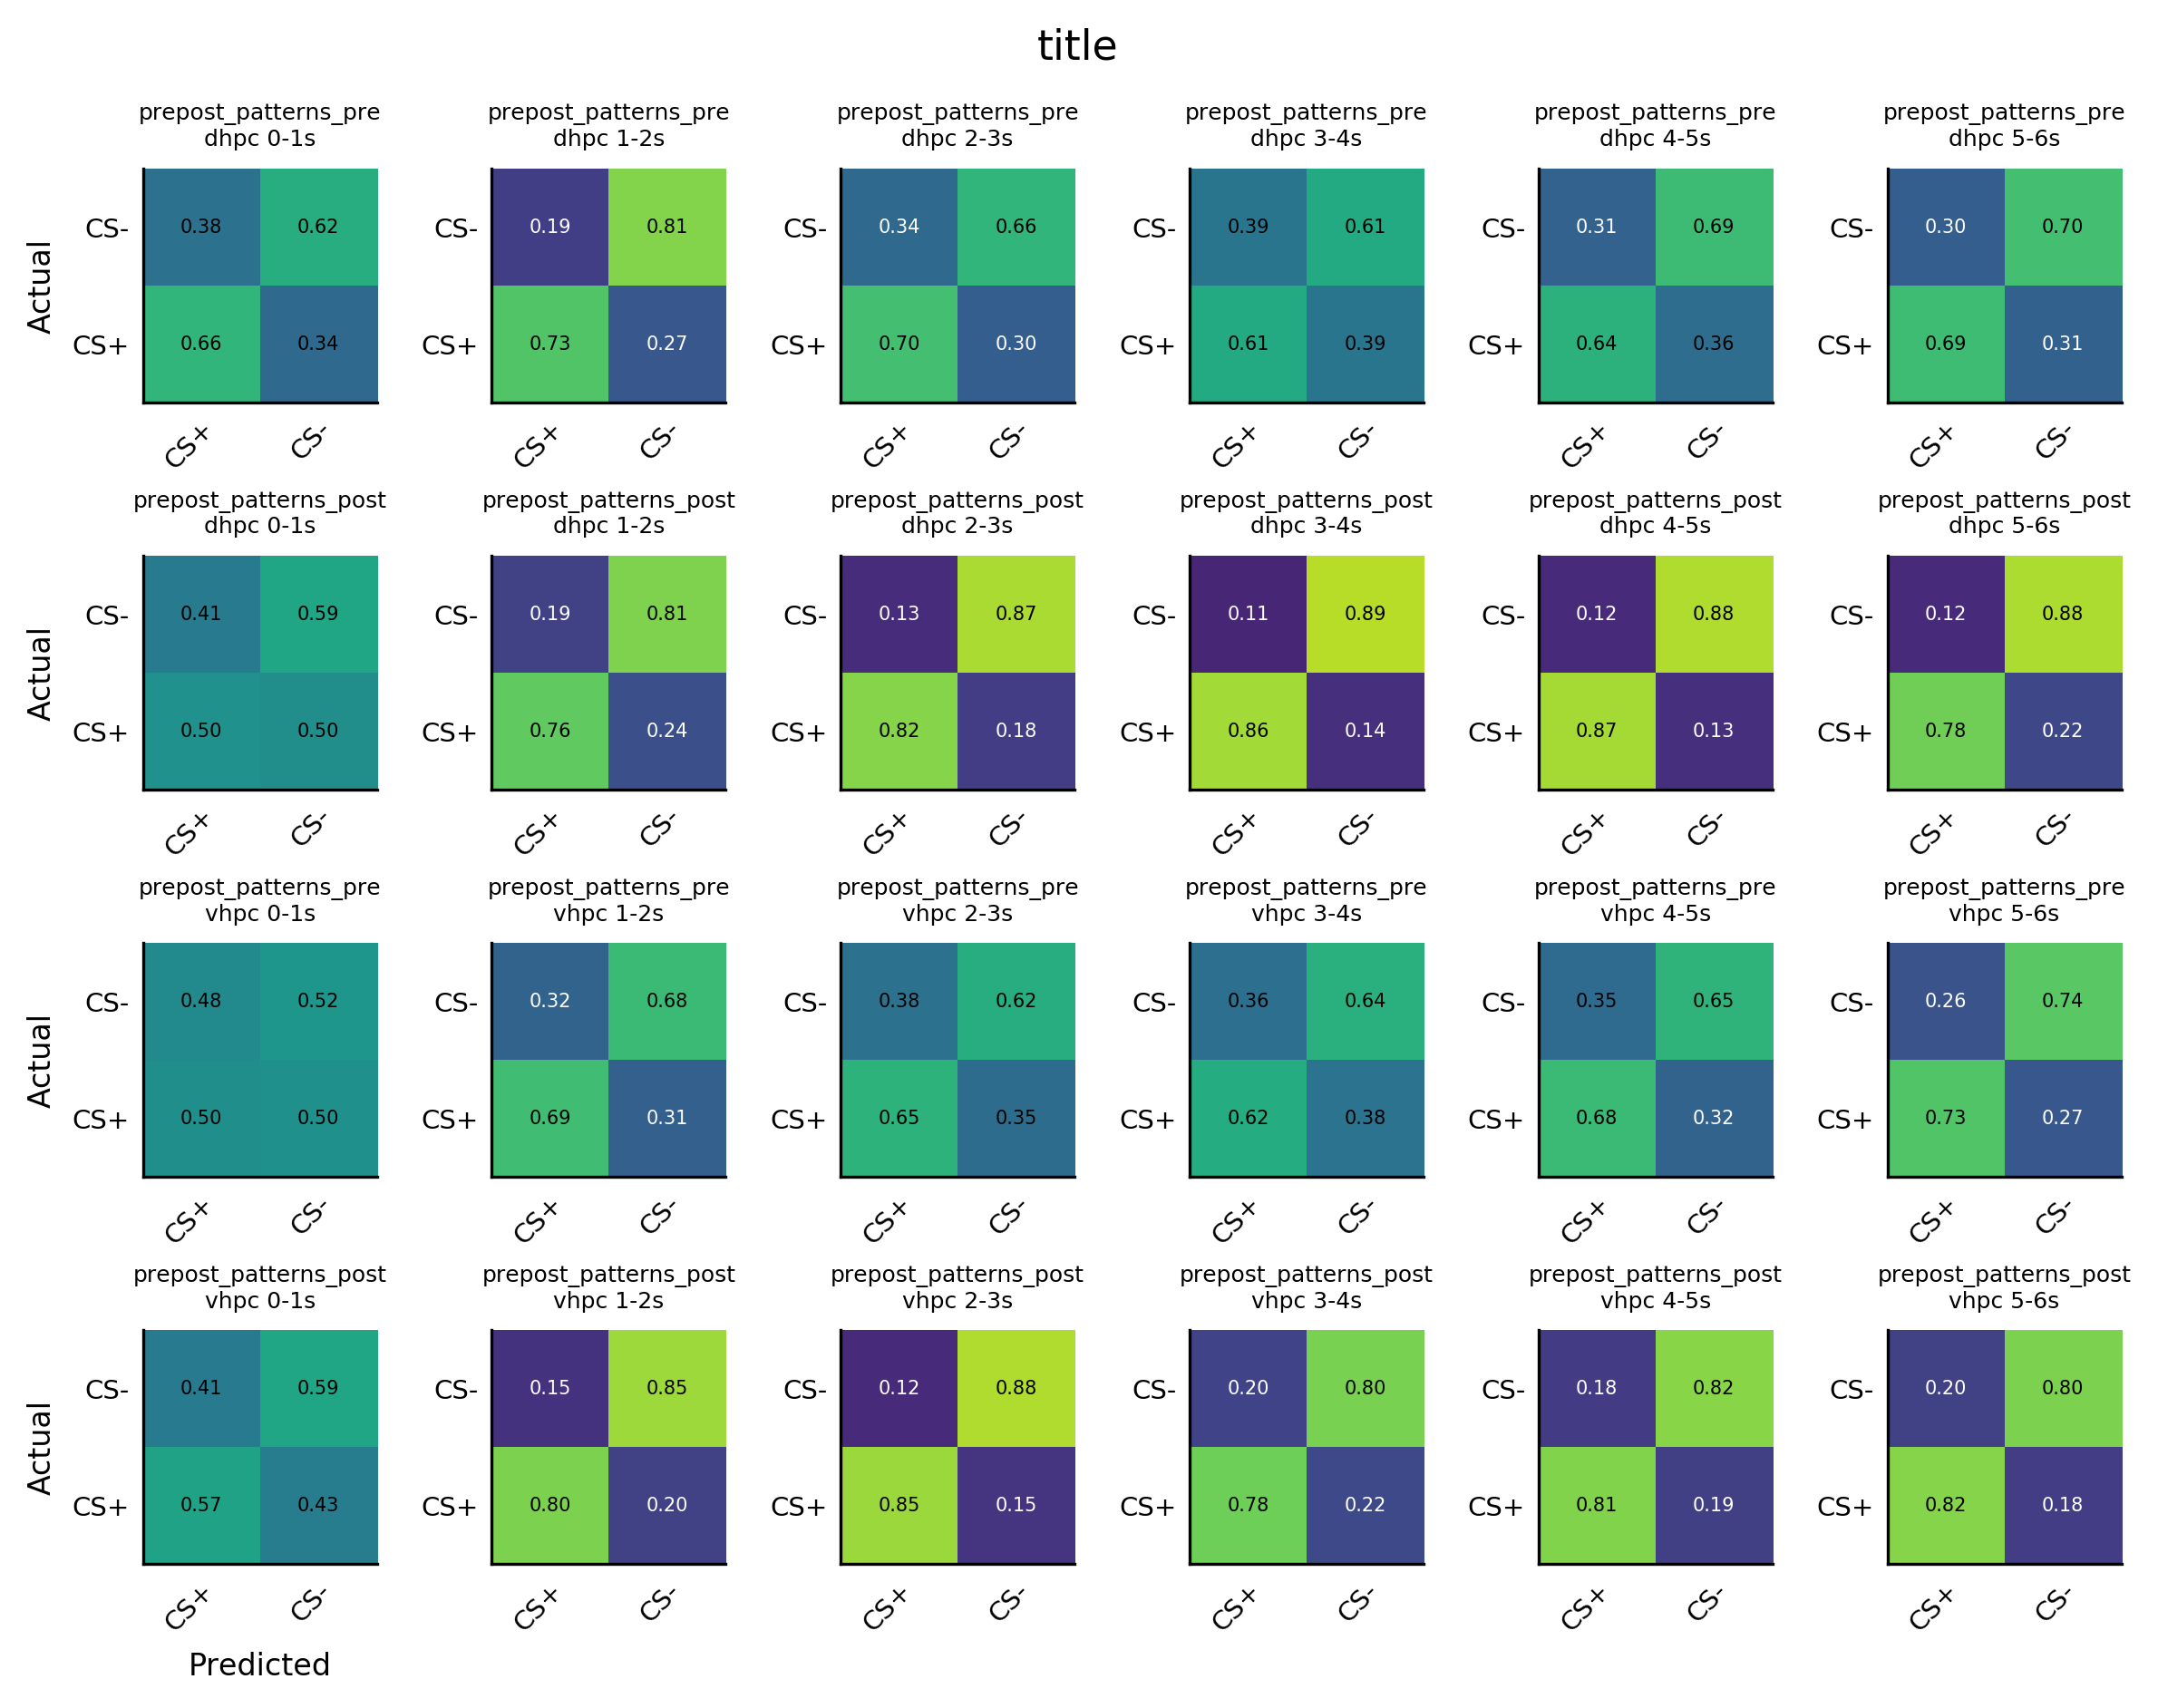

In [76]:
# plot 'em all
fig, ((ax1, ax2, ax3, ax4, ax5, ax6),(ax7,ax8,ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16,ax17,ax18),(ax19,ax20,ax21,ax22,ax23,ax24)) = pl.subplots(4, 6, figsize=(8, 6))

for reg,r in zip(regions,(0,12)):
    for i,j,la in zip(range(5,11),range(1,7),('0-1s','1-2s','2-3s','3-4s','4-5s','5-6s')):
        for comp,k in zip(['prepost_patterns_pre','prepost_patterns_post'],[0,6]):
            q=j+k+r
            im = heatmap(eval("2.*heatmaps_%s_%s[i]/np.sum(heatmaps_%s_%s[i])"%(reg,comp,reg,comp)),(['CS+','CS-']),
                         (['CS+','CS-']), ax=eval('ax%s'%q),vmin=0,vmax=1)
            annotate_heatmap(im, valfmt="{x:.2f}", size=5)
            eval('ax%s'%q).set_title(eval('"%s\\n%s %s"'%(comp,reg,la)),fontsize=6)
for x in 19,:
    eval('ax%s.set_xlabel'%x)('Predicted',fontsize=8)
for x in 1,7,13,19:
    eval('ax%s.set_ylabel'%x)('Actual',fontsize=8)
pl.suptitle('title',fontsize=11,y=1.03)
    
pl.tight_layout(pad=2)
pl.show()
#fig.savefig('../figures/%s_CSpm_cross_1s.pdf'%NOTEBOOK_NAME)

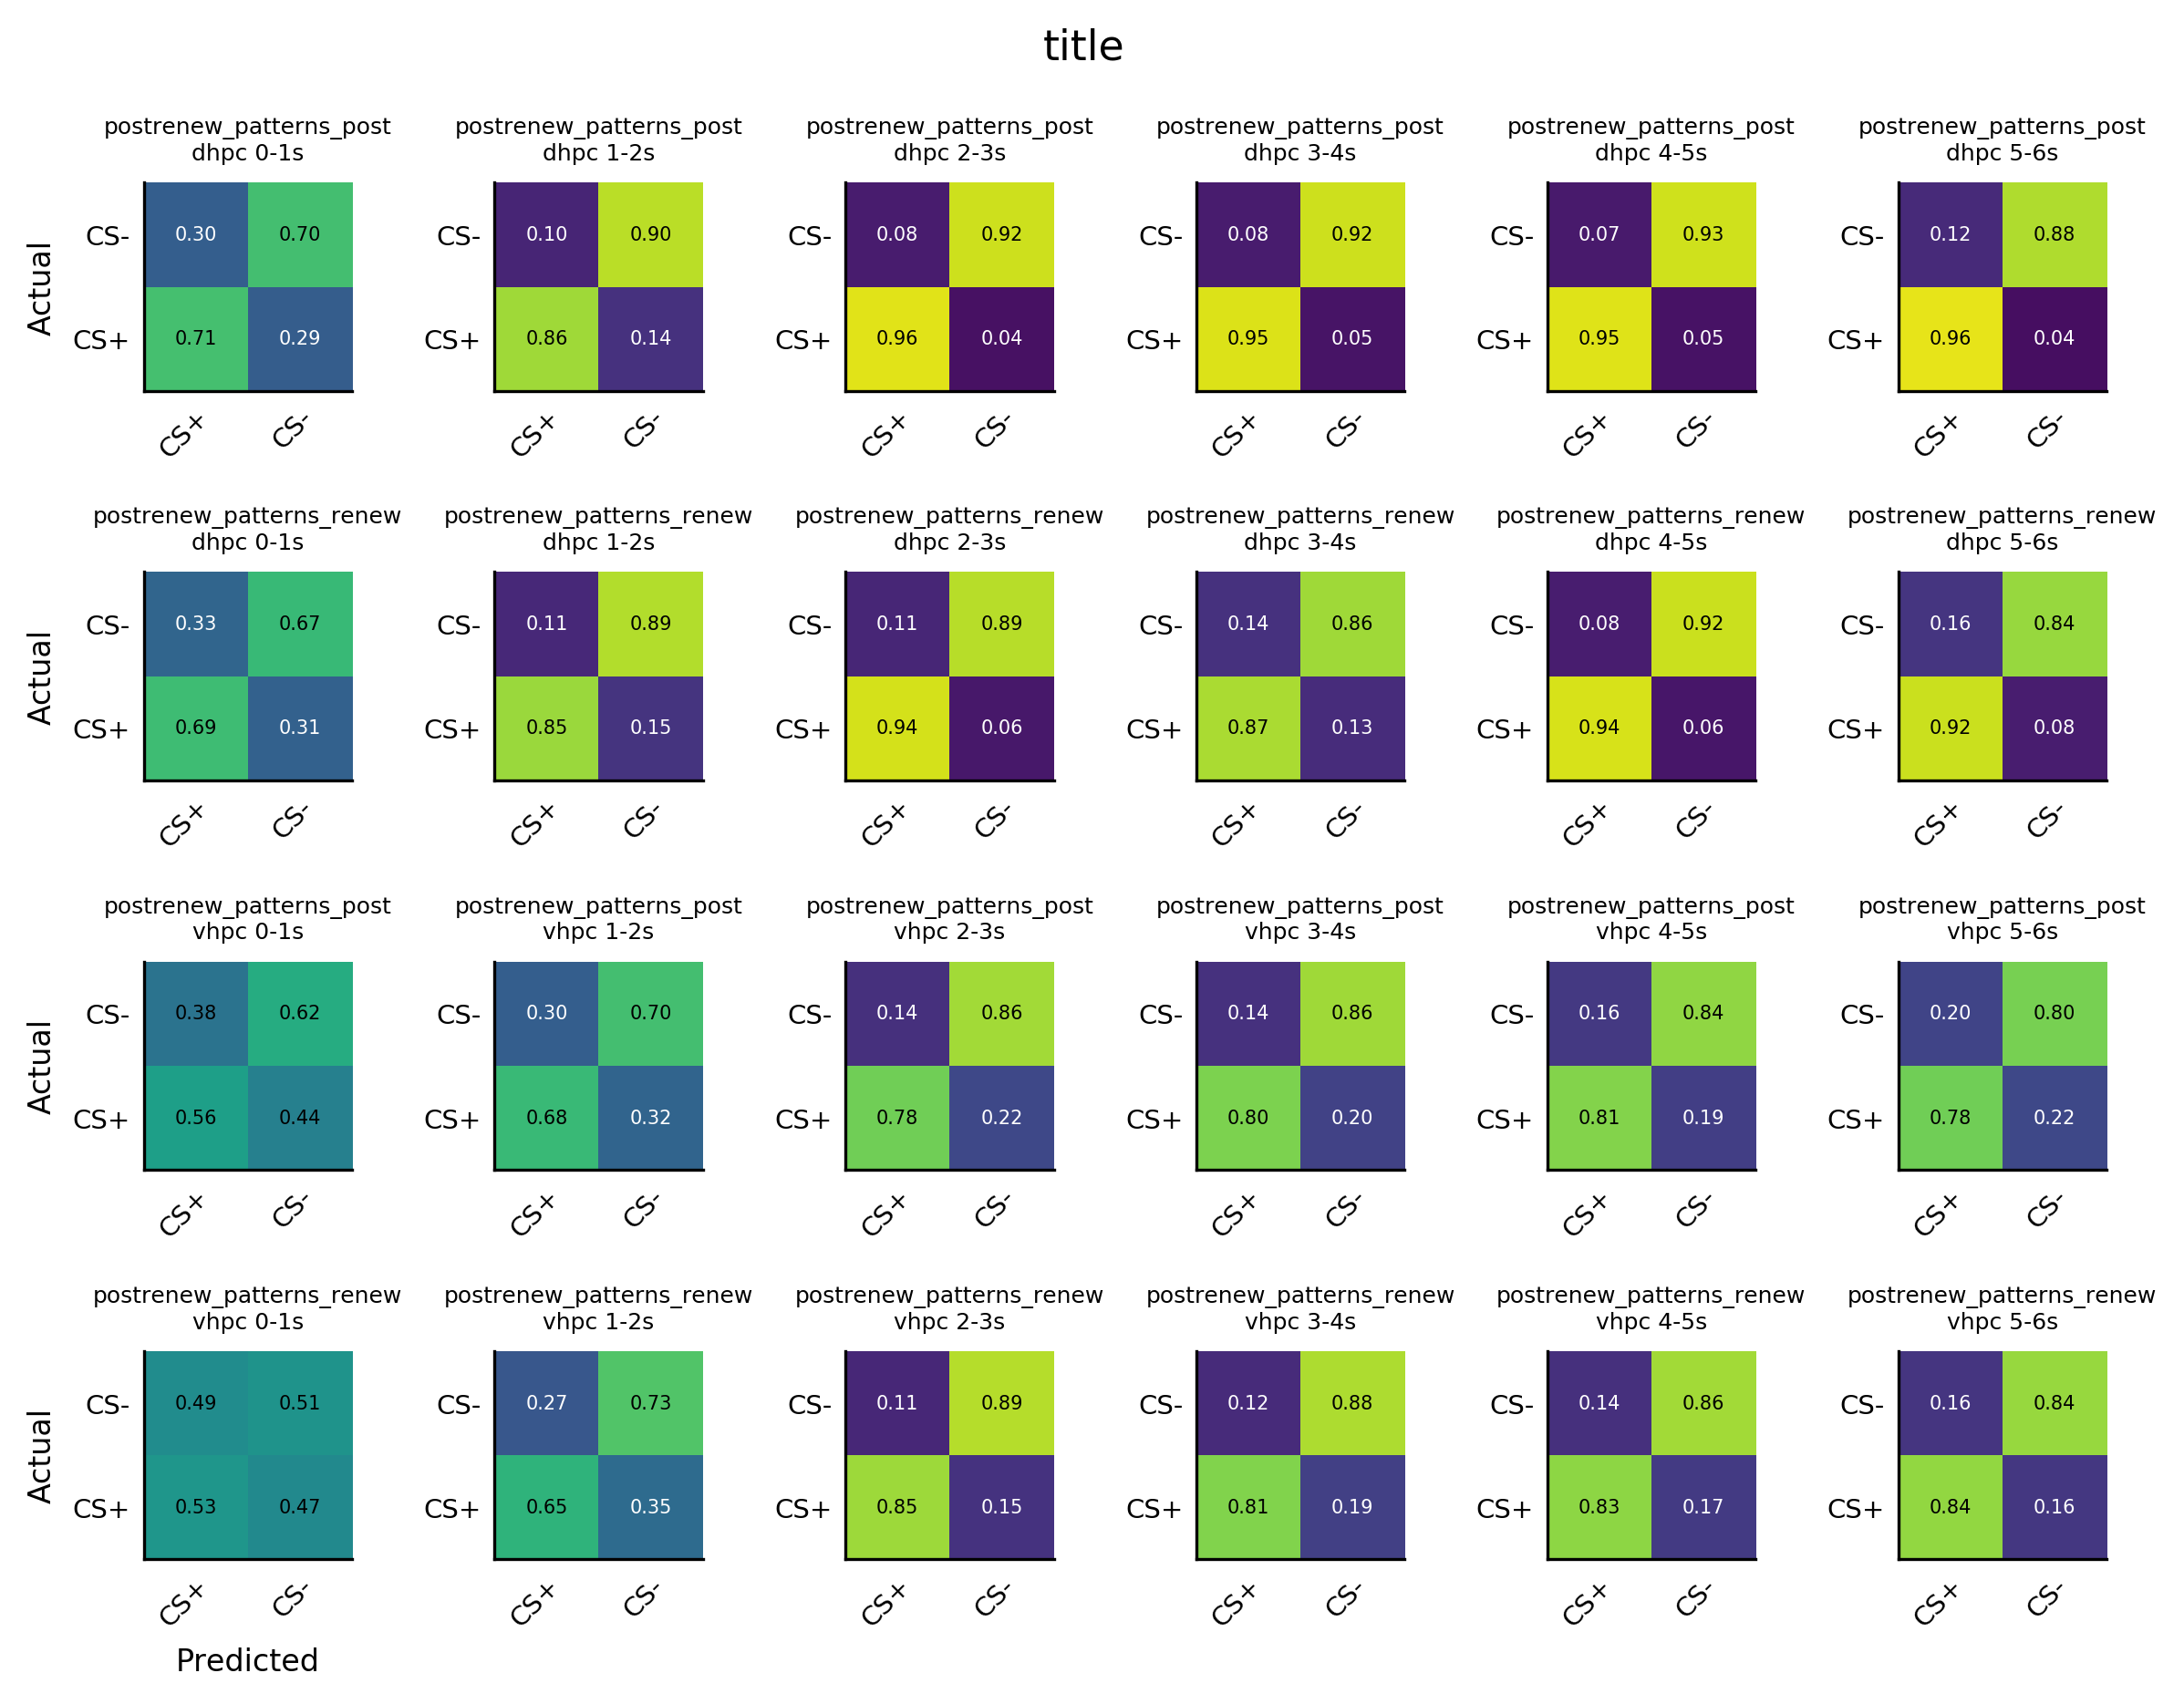

In [80]:
# plot 'em all
fig, ((ax1, ax2, ax3, ax4, ax5, ax6),(ax7,ax8,ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16,ax17,ax18),(ax19,ax20,ax21,ax22,ax23,ax24)) = pl.subplots(4, 6, figsize=(8, 6))

for reg,r in zip(regions,(0,12)):
    for i,j,la in zip(range(5,11),range(1,7),('0-1s','1-2s','2-3s','3-4s','4-5s','5-6s')):
        for comp,k in zip(['postrenew_patterns_post','postrenew_patterns_renew'],[0,6]):
            q=j+k+r
            im = heatmap(eval("2.*heatmaps_%s_%s[i]/np.sum(heatmaps_%s_%s[i])"%(reg,comp,reg,comp)),(['CS+','CS-']),
                         (['CS+','CS-']), ax=eval('ax%s'%q),vmin=0,vmax=1)
            annotate_heatmap(im, valfmt="{x:.2f}", size=5)
            eval('ax%s'%q).set_title(eval('"%s\\n%s %s"'%(comp,reg,la)),fontsize=6)
for x in 19,:
    eval('ax%s.set_xlabel'%x)('Predicted',fontsize=8)
for x in 1,7,13,19:
    eval('ax%s.set_ylabel'%x)('Actual',fontsize=8)
pl.suptitle('title',fontsize=11,y=1.03)
    
pl.tight_layout(pad=2)
pl.show()
#fig.savefig('../figures/%s_CSpm_cross_1s.pdf'%NOTEBOOK_NAME)

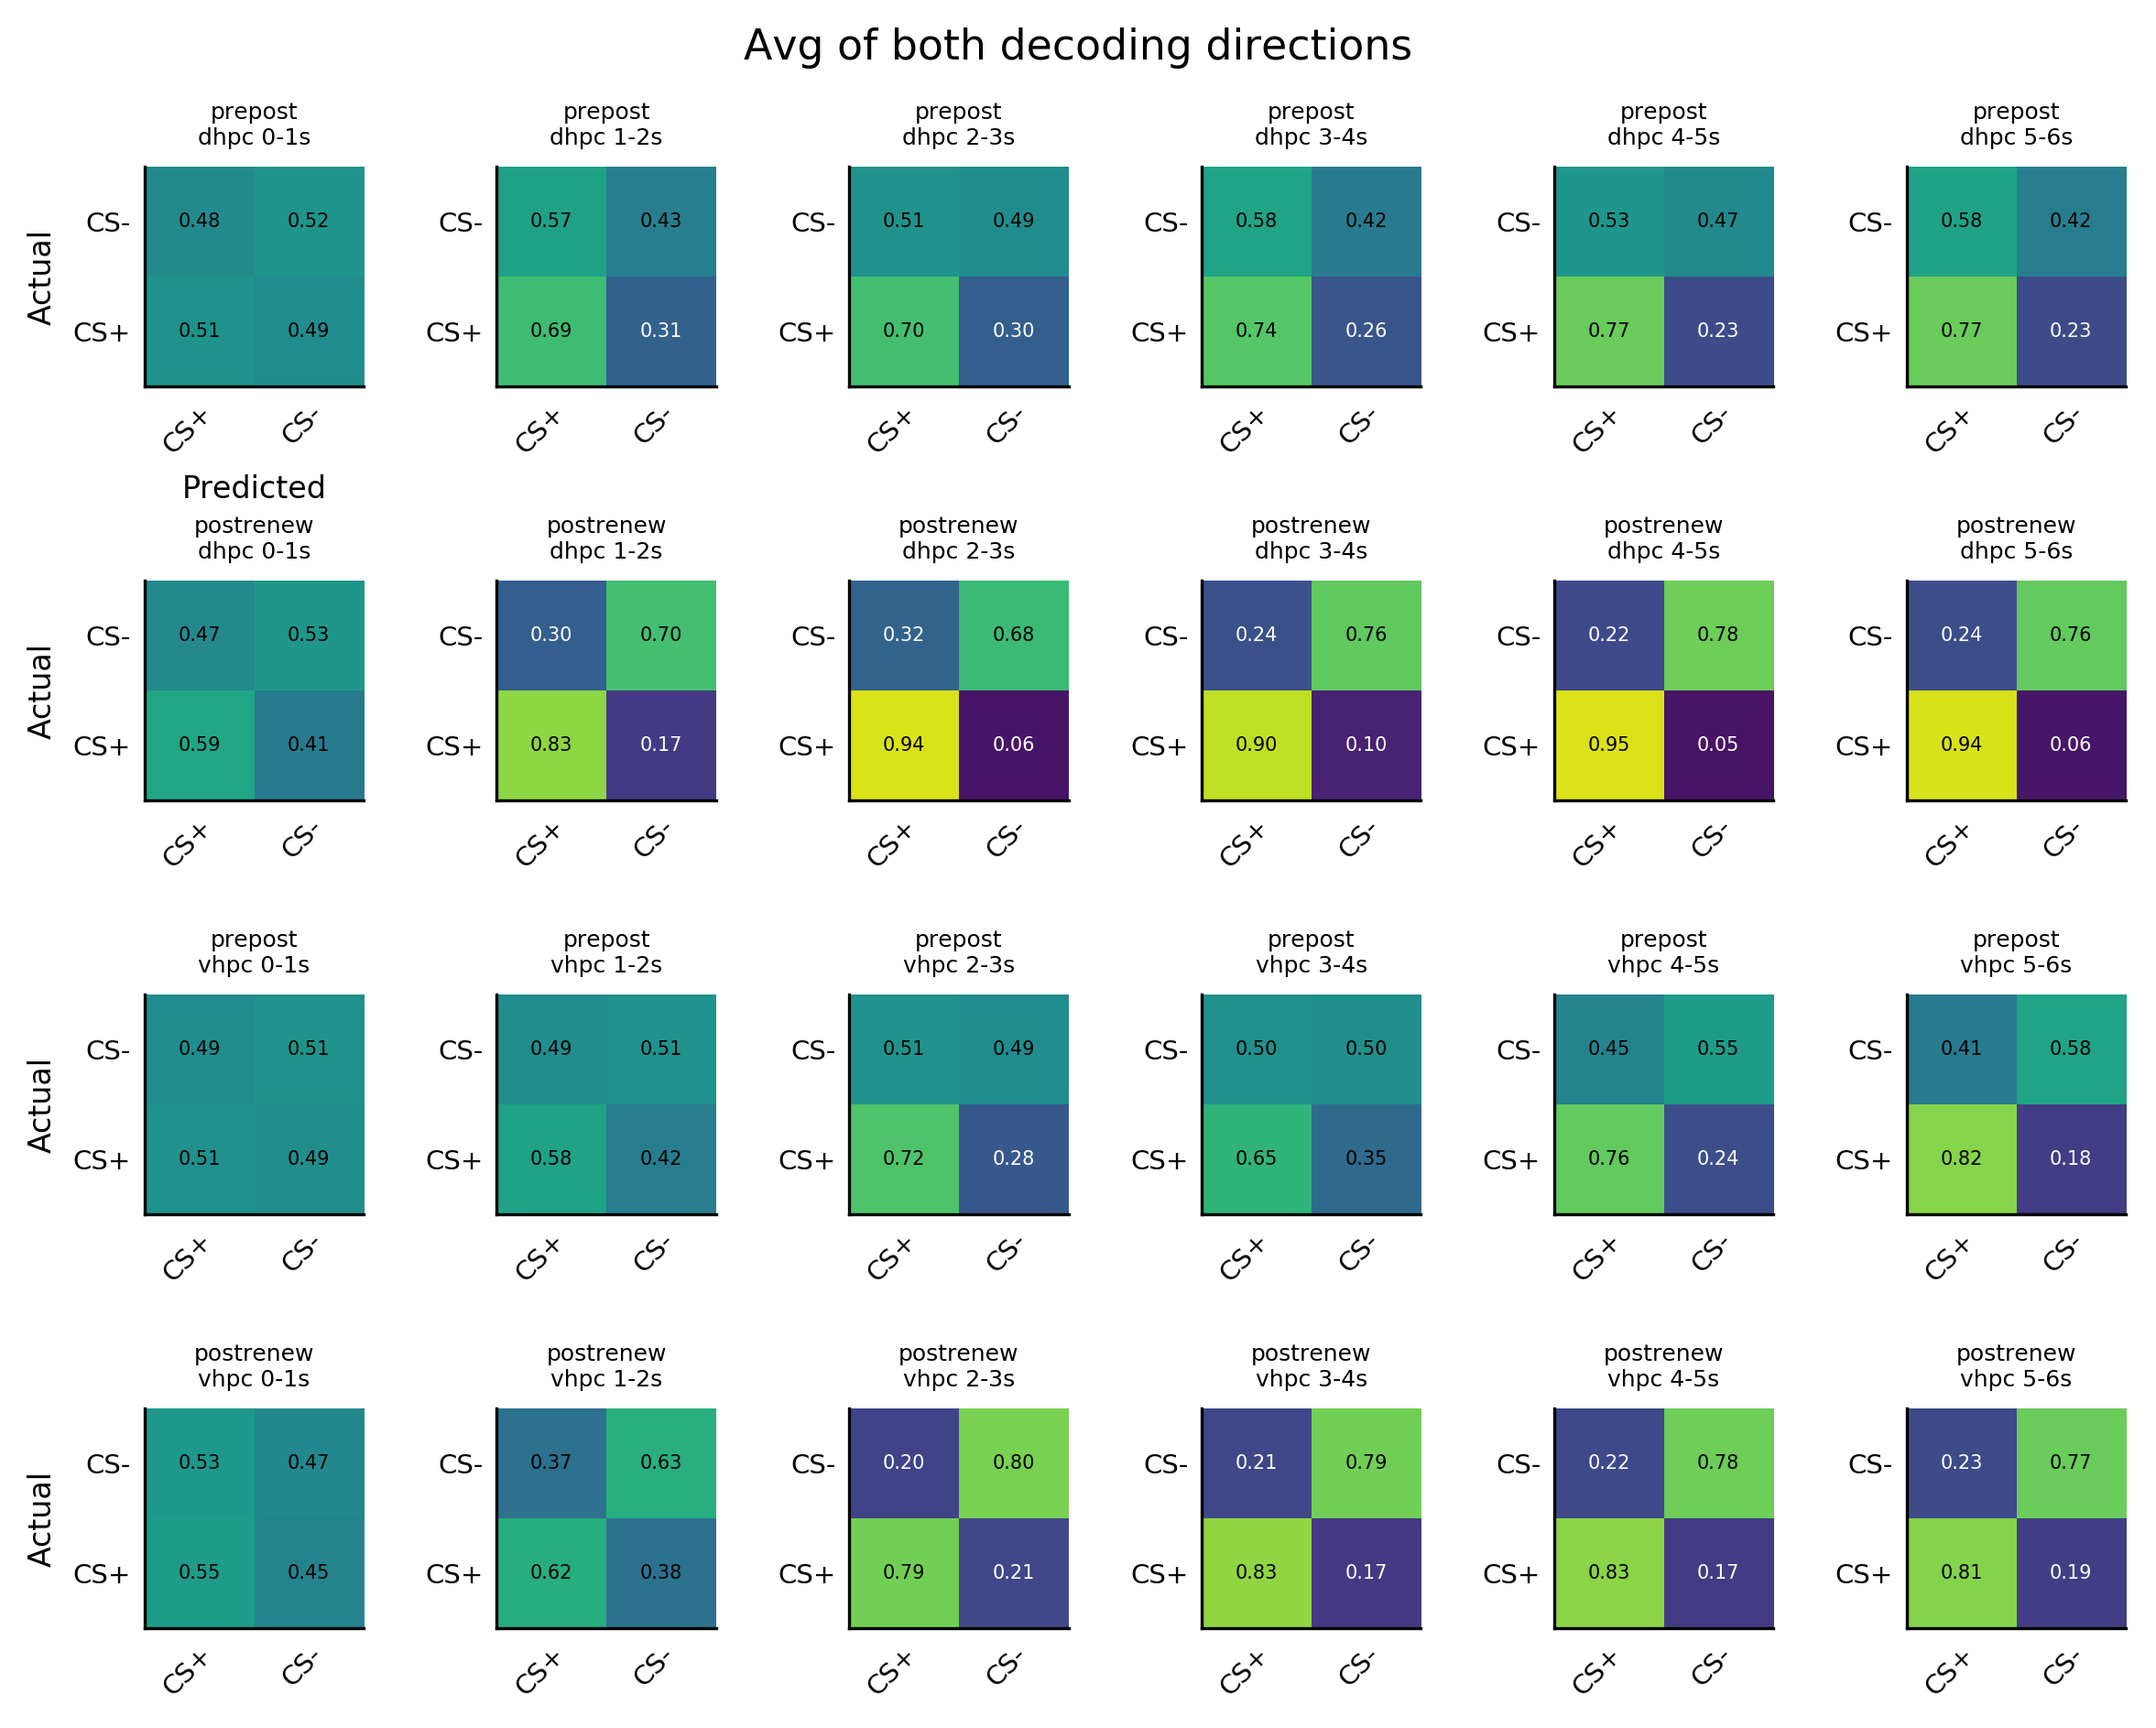

In [79]:
# plot 'em all
fig, ((ax1, ax2, ax3, ax4, ax5, ax6),(ax7,ax8,ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16,ax17,ax18),(ax19,ax20,ax21,ax22,ax23,ax24)) = pl.subplots(4, 6, figsize=(8, 6))

for reg,r in zip(regions,(0,12)):
    for i,j,la in zip(range(5,11),range(1,7),('0-1s','1-2s','2-3s','3-4s','4-5s','5-6s')):
        for comp,k in zip(['prepost','postrenew'],[0,6]):
            q=j+k+r
            im = heatmap(eval("2.*np.mean((heatmaps_test_%s_%s,heatmaps_train_%s_%s),0)[i]/np.sum(heatmaps_test_%s_%s[i])"%(reg,comp,reg,comp,reg,comp)),(['CS+','CS-']),
                         (['CS+','CS-']), ax=eval('ax%s'%q),vmin=0,vmax=1)
            annotate_heatmap(im, valfmt="{x:.2f}", size=5)
            eval('ax%s'%q).set_title(eval('"%s\\n%s %s"'%(comp,reg,la)),fontsize=6)
for x in 1,:
    eval('ax%s.set_xlabel'%x)('Predicted',fontsize=8)
for x in 1,7,13,19:
    eval('ax%s.set_ylabel'%x)('Actual',fontsize=8)
pl.suptitle('Avg of both decoding directions',fontsize=11,y=1.03)
    
pl.tight_layout(pad=2)
pl.show()
#fig.savefig('../figures/%s_CSpm_cross_1s.pdf'%NOTEBOOK_NAME)

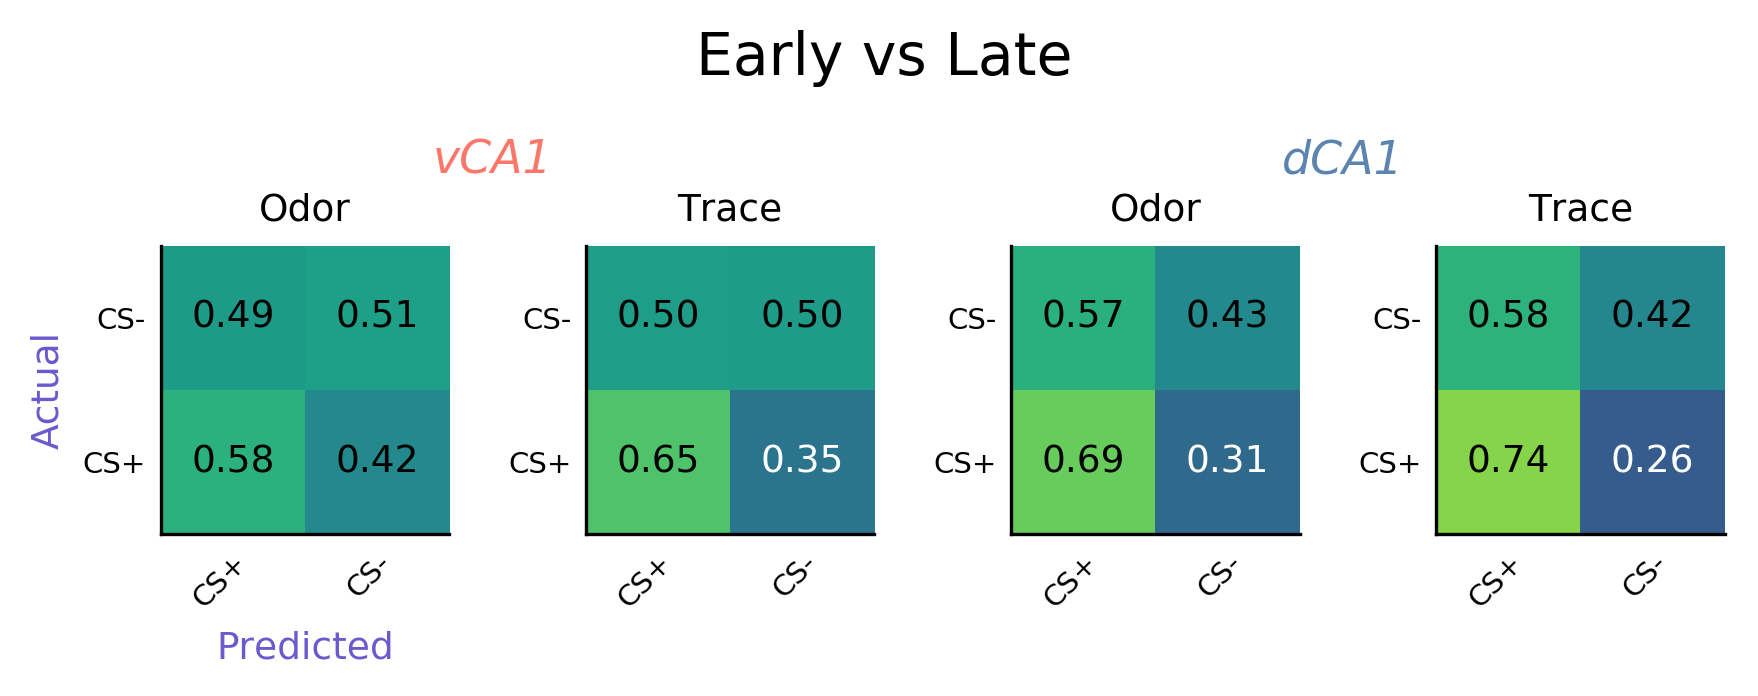

In [85]:
# plot 'em all
comp='prepost'
fig, ((ax1, ax2, ax3, ax4)) = pl.subplots(1, 4, figsize=(6, 2.5))

for reg,r in zip(('vhpc','dhpc'),(0,2)):
    for i,j,la in zip((6,8),(1,2),('Odor','Trace')):
        q=j+r
        im = heatmap(eval("2.*np.mean((heatmaps_test_%s_%s,heatmaps_train_%s_%s),0)[i]/np.sum(heatmaps_test_%s_%s[i])"%(reg,comp,reg,comp,reg,comp)),(['CS+','CS-']),
                     (['CS+','CS-']), ax=eval('ax%s'%q),vmin=0,vmax=.9,cmap='viridis')
        annotate_heatmap(im, valfmt="{x:.2f}", size=9,threshold=.41)
        #eval('ax%s'%q).set_title(eval('"%s"'%(la)),fontsize=9)
ax1.set_title('Odor',fontsize=9)
ax2.set_title('Trace',fontsize=9)
ax3.set_title('Odor',fontsize=9)
ax4.set_title('Trace',fontsize=9)
for x in range(1,7):
    ax1.set_xlabel('Predicted',fontsize=9,color='slateblue')
    ax1.set_ylabel('Actual',fontsize=9,color='slateblue')
#pl.suptitle('vCA1',fontsize=11,y=1)
ax1.text(1.8,2,'vCA1',color='#FC766AFF',fontstyle='italic',fontsize=11,ha='center')
ax3.text(1.8,2,'dCA1',color='#5B84B1FF',fontstyle='italic',fontsize=11,ha='center')

pl.suptitle('Early vs Late',fontsize=14,color='k')
pl.tight_layout(h_pad=4)
pl.show()
fig.savefig('../final-ish figures/%s_confmat_dv_1s_PrPo.pdf'%NOTEBOOK_NAME)

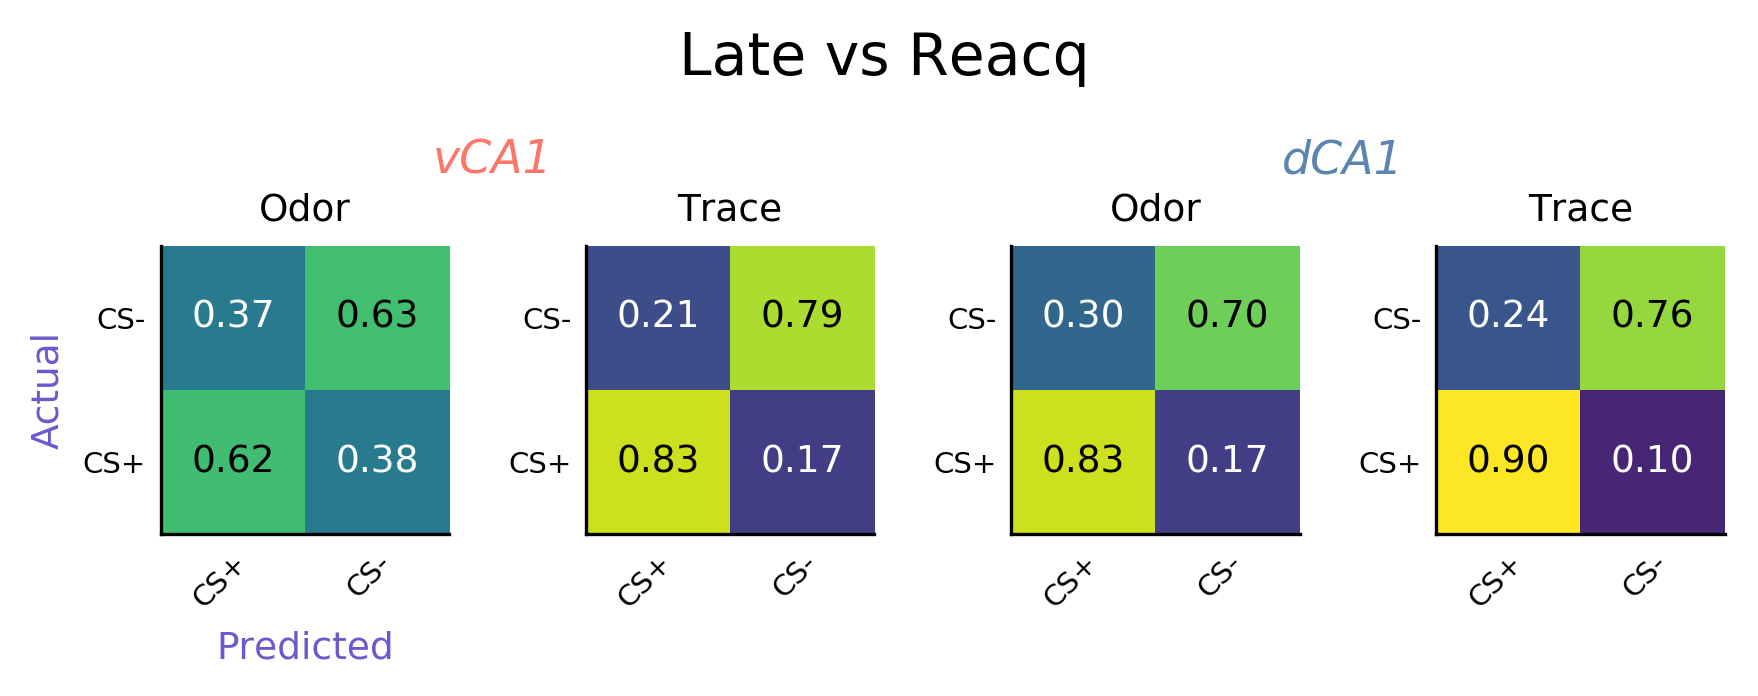

In [86]:
# plot 'em all
comp='postrenew'
fig, ((ax1, ax2, ax3, ax4)) = pl.subplots(1, 4, figsize=(6, 2.5))

for reg,r in zip(('vhpc','dhpc'),(0,2)):
    for i,j,la in zip((6,8),(1,2),('Odor','Trace')):
        q=j+r
        im = heatmap(eval("2.*np.mean((heatmaps_test_%s_%s,heatmaps_train_%s_%s),0)[i]/np.sum(heatmaps_test_%s_%s[i])"%(reg,comp,reg,comp,reg,comp)),(['CS+','CS-']),
                     (['CS+','CS-']), ax=eval('ax%s'%q),vmin=0,vmax=.9,cmap='viridis')
        annotate_heatmap(im, valfmt="{x:.2f}", size=9,threshold=.41)
        #eval('ax%s'%q).set_title(eval('"%s"'%(la)),fontsize=9)
ax1.set_title('Odor',fontsize=9)
ax2.set_title('Trace',fontsize=9)
ax3.set_title('Odor',fontsize=9)
ax4.set_title('Trace',fontsize=9)
for x in range(1,7):
    ax1.set_xlabel('Predicted',fontsize=9,color='slateblue')
    ax1.set_ylabel('Actual',fontsize=9,color='slateblue')
#pl.suptitle('vCA1',fontsize=11,y=1)
ax1.text(1.8,2,'vCA1',color='#FC766AFF',fontstyle='italic',fontsize=11,ha='center')
ax3.text(1.8,2,'dCA1',color='#5B84B1FF',fontstyle='italic',fontsize=11,ha='center')

pl.suptitle('Late vs Reacq',fontsize=14,color='k')
pl.tight_layout(h_pad=4)
pl.show()
fig.savefig('../final-ish figures/%s_confmat_dv_1s_PoRe.pdf'%NOTEBOOK_NAME)

# left off here

In [81]:
save_workspace(db)

Could not store variable 'IPython'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'matplotlib'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
